# **Practical Block I - Dermatological Moles Segmentation**     

**Axel Romero**      

*Deep Learning for Medical Image Analysis Course*

**Table of contents**     

1. Dataset - ISC 2016 Challenge     
2. Preprocess the images and masks      
3. Create datasets     
4. Models  
  4.1 U-Net - Original data    
  4.2 Attention U-Net - Original data    
  4.3 U-Net - Zoom normalized data    
  4.4 Attention U-Net - Zoom normalized data
5. Comparison of the models    
6. Predictions of the test set    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import zipfile
import tensorflow as tf
import keras
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset - ISC 2016 Challenge**

First, we define the constants and paths used in this notebook. We will work with a size of 256 x 256 for all images in the dataset.

In [3]:
ROOT_PATH = '/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation'

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMAGE_DIR = os.path.join(ROOT_PATH, 'images')
MASK_DIR = os.path.join(ROOT_PATH, 'masks')

In [4]:
image_paths = [os.path.join(IMAGE_DIR, filename) for filename in os.listdir(IMAGE_DIR)]
mask_paths = [os.path.join(MASK_DIR, filename) for filename in os.listdir(MASK_DIR)]

# Clean the paths with repeated images that starts with .
image_paths = [item for item in image_paths if not item.split('/')[-1].startswith('.')]
mask_paths = [item for item in mask_paths if not item.split('/')[-1].startswith('.')]

In [5]:
print(image_paths[:2])
print(mask_paths[:2])

['/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation/images/ISIC_0010068.jpg', '/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation/images/ISIC_0009938.jpg']
['/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation/masks/ISIC_0011169_Segmentation.png', '/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation/masks/ISIC_0010594_Segmentation.png']


In [6]:
print("Number of images in the dataset: ", len(image_paths))
print("Number of masks in the dataset: ", len(mask_paths))

Number of images in the dataset:  900
Number of masks in the dataset:  900


In [7]:
# Extract the IDs of the samples
samples_id = [item.split('/')[-1].split('.')[0] for item in image_paths]
samples_id[:5]

['ISIC_0010068',
 'ISIC_0009938',
 'ISIC_0010248',
 'ISIC_0010324',
 'ISIC_0010000']

Visualisation of some images and their corresponding mask.

In [ ]:
images = []
masks = []

for id in samples_id[:5]:
  # Read the images
  img = Image.open(os.path.join(IMAGE_DIR, id+'.jpg'))
  img = np.array(img)
  images.append(img)

  # Read the masks
  mask = Image.open(os.path.join(MASK_DIR, id+'_Segmentation.png'))
  mask = np.array(mask)
  mask = np.expand_dims(mask, -1)
  masks.append(mask)

Here we can see the original size of the images and masks of the dataset. We are going to reduce the size in order to reduce the computational cost.

In [ ]:
print("Size of the images: ", images[0].shape)
print("Size of the masks: ", masks[0].shape)

Size of the images:  (768, 1024, 3)
Size of the masks:  (768, 1024, 1)


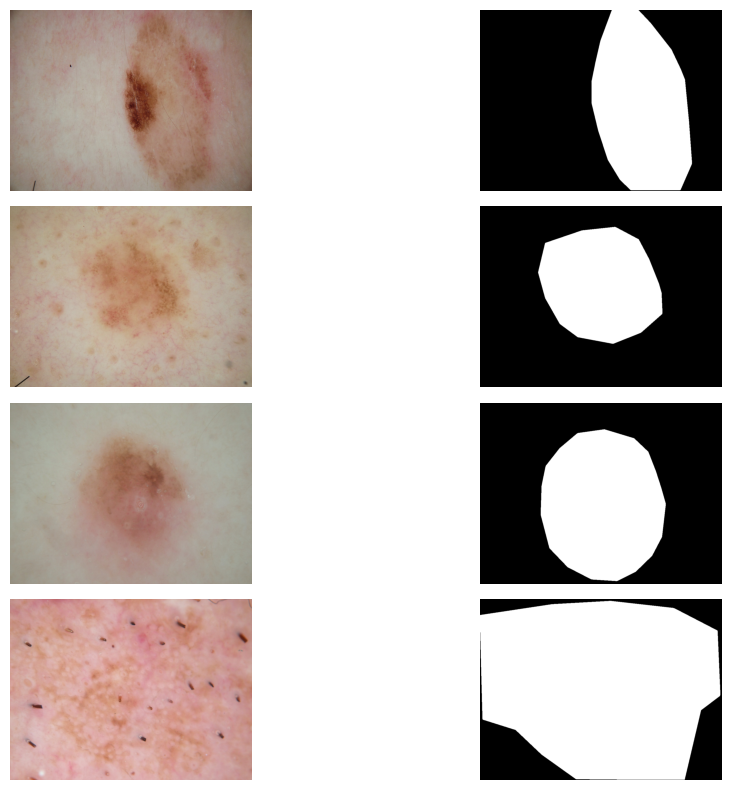

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))

for i in range(len(images)-1):
  axs[i,0].imshow(images[i])
  axs[i, 0].axis('off')
  axs[i,1].imshow(masks[i], cmap='gray')
  axs[i, 1].axis('off')

fig.tight_layout()
plt.show()

## **Preprocess the images and masks**

In this section we analyze the images and masks of the dataset and perform some preprocess in order to improve the performance of the following segmentation models.

We can see that not all images have moles of the same size, which means that the zoom is not the same for all images. For some, the image was taken very close to the mole and for others the image was taken some distance apart. We can analyse this behaviour using the masks, where a high proportion of ones indicates that the mole occupies a lot of space in the image and a low proportion of ones indicates that the mole is too small, too little zoom.

In [ ]:
proportion_of_ones = []
for mask in tqdm(mask_paths):
  mask_img = Image.open(mask)
  mask_img_np = np.array(mask_img) / 255
  ones = np.sum(mask_img_np[mask_img_np == 1.0])
  proportion_of_ones.append(ones / (mask_img_np.shape[0]*mask_img_np.shape[1]))

100%|██████████| 900/900 [00:36<00:00, 24.69it/s] 


In [ ]:
print("Mean of the proportion of ones: ", np.mean(proportion_of_ones))
print("Standard deviation of the proportion of ones: ", np.std(proportion_of_ones))
print("Minimum value of the proportion of ones: ", np.min(proportion_of_ones))
print("Maximum value of the proportion of ones: ", np.max(proportion_of_ones))

Mean of the proportion of ones:  0.27087347785981225
Standard deviation of the proportion of ones:  0.21407966646890064
Minimum value of the proportion of ones:  0.011554718017578125
Maximum value of the proportion of ones:  0.9954388936360677


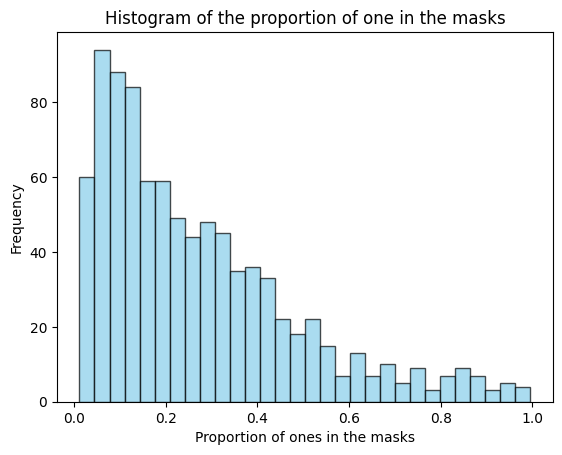

In [ ]:
# Create a histogram
plt.hist(proportion_of_ones, bins=30, edgecolor='black', alpha=0.7, color='skyblue')

# Add labels and a title
plt.xlabel('Proportion of ones in the masks')
plt.ylabel('Frequency')
plt.title('Histogram of the proportion of one in the masks')

# Display the histogram
plt.show()

With the analysis of proportion of ones we can see a high standard deviation of this value, which indicates that there is a high variability in the size (zoom) of the images. Also, the mean indicates that, in average, the ones occupies the 27% of each mask.

In order to overcome this problem of high variability in the dataset we can preprocess the images by normalizing the size of the mole, the zoom of the image. One approach is to use the mask to detect the area of the mole and add a padding of fixed size in order to have all the image with a similar size. We generate a new dataset with the normalized images and masks.

In [8]:
# Path to store the normalized dataset
OUT_DIR = '/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation_normalized'
OUT_DIR_IMAGE = '/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation_normalized/images'
OUT_DIR_MASK = '/content/drive/MyDrive/DLMIA/Practical_Block_1/data/Lesion_Segmentation_normalized/masks'


os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(OUT_DIR_IMAGE, exist_ok=True)
os.makedirs(OUT_DIR_MASK, exist_ok=True)

In [ ]:
# Function to process each image
def process_image(name):

    padding = 10

    image_path = os.path.join(IMAGE_DIR, name+'.jpg')
    mask_path = os.path.join(MASK_DIR, name+'_Segmentation.png')

    # Load the image and mask
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    # Find contours in the mask to determine the bounding box
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Find the bounding box of the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the region of interest (ROI) from the original image and mask
        image_roi = image[y:y + h, x:x + w]
        mask_roi = mask[y:y + h, x:x + w]

        # Resize the ROI to the target size
        image_resized = cv2.resize(image_roi, (IMG_WIDTH - 2 * padding, IMG_HEIGHT - 2 * padding))
        mask_resized = cv2.resize(mask_roi, (IMG_WIDTH - 2 * padding, IMG_HEIGHT - 2 * padding))

        # Create a new image with padding
        padded_image = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)
        padded_mask = np.zeros((IMG_WIDTH, IMG_HEIGHT), dtype=np.uint8)

        # Place the resized ROI in the center of the padded image
        padded_image[padding:padding + IMG_WIDTH - 2 * padding, padding:padding + IMG_HEIGHT - 2 * padding] = image_resized
        padded_mask[padding:padding + IMG_WIDTH - 2 * padding, padding:padding + IMG_HEIGHT - 2 * padding] = mask_resized

        # Save the padded image and mask
        output_image_path = os.path.join(OUT_DIR_IMAGE, name+'.jpg')
        output_mask_path = os.path.join(OUT_DIR_MASK, f"{name}_Segmentation.png")

        cv2.imwrite(output_image_path, padded_image)
        cv2.imwrite(output_mask_path, padded_mask)

In [ ]:
with ProcessPoolExecutor(max_workers=1) as executor:
  list(tqdm(executor.map(process_image, samples_id), total=len(samples_id)))

100%|██████████| 900/900 [07:53<00:00,  1.90it/s]


In [ ]:
proportion_of_ones_2 = []
normalized_mask_paths = os.listdir(OUT_DIR_MASK)

for mask in tqdm(normalized_mask_paths):
  mask_img = Image.open(os.path.join(OUT_DIR_MASK, mask))
  mask_img_np = np.array(mask_img) / 255
  ones = np.sum(mask_img_np[mask_img_np == 1.0])
  proportion_of_ones_2.append(ones / (mask_img_np.shape[0]*mask_img_np.shape[1]))

100%|██████████| 900/900 [00:02<00:00, 386.64it/s]


In [ ]:
print("Mean of the proportion of ones: ", np.mean(proportion_of_ones_2))
print("Standard deviation of the proportion of ones: ", np.std(proportion_of_ones_2))
print("Minimum value of the proportion of ones: ", np.min(proportion_of_ones_2))
print("Maximum value of the proportion of ones: ", np.max(proportion_of_ones_2))

Mean of the proportion of ones:  0.5912109544542101
Standard deviation of the proportion of ones:  0.06649531185399642
Minimum value of the proportion of ones:  0.3473663330078125
Maximum value of the proportion of ones:  0.84625244140625


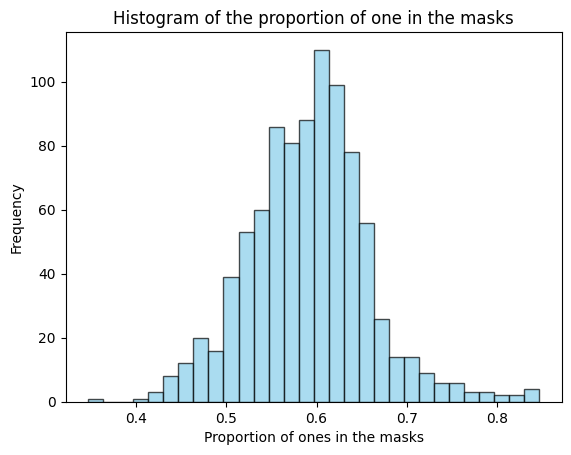

In [ ]:
# Create a histogram
plt.hist(proportion_of_ones_2, bins=30, edgecolor='black', alpha=0.7, color='skyblue')

# Add labels and a title
plt.xlabel('Proportion of ones in the masks')
plt.ylabel('Frequency')
plt.title('Histogram of the proportion of one in the masks')

# Display the histogram
plt.show()

Now, we can see that there is less variability in the proportion of ones in the masks and the mean proportion is arround 0.5, which indicates that the classes 0 and 1 are balanced.

In [9]:
image_paths_norm = [os.path.join(OUT_DIR_IMAGE, filename) for filename in os.listdir(OUT_DIR_IMAGE)]
mask_paths_norm = [os.path.join(OUT_DIR_MASK, filename) for filename in os.listdir(OUT_DIR_MASK)]

## **Create datasets**

First, we define three useful functions used in the definition of the datasets and the visualization of them. In this practical exercise we are going to define two different datasets, one with the original dataset without zoom normalization and, the other one, with the zoom normalized data as explained in the previous section. As we will see in the following sections, we are going to train and evaluate our models in both cases in order to see if there is an important impact of this normalization in the performance of the models.    
    \\

In both datasets we have divided the data into training, validation and testing, the sizes of the datasets being:
- 70% for training
- 10% for validation
- 20% for testing

In [10]:
def load_and_preprocess_image_w_augmentation(root, name):
  # Load and preprocess image
  image = tf.io.read_file(os.path.join(root, 'images/'+name+'.jpg'))
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))  # Resize to desired dimensions

  # Load and preprocess mask
  mask = tf.io.read_file(os.path.join(root, 'masks/'+name+'_Segmentation.png'))
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = mask // 255  # Convert to binary mask (0 or 1)

  # Combine image and mask for data augmentation
  combined = tf.concat([image, tf.cast(mask, tf.float32)], axis=-1)

  # Data augmentation
  combined = tf.image.random_flip_left_right(combined)
  combined = tf.image.random_brightness(combined, max_delta=0.2)
  combined = tf.image.random_contrast(combined, lower=0.7, upper=1.3)
  combined = tf.image.random_crop(combined, size=(IMG_HEIGHT, IMG_WIDTH, 4))

  return image, mask


def load_and_preprocess_image_wo_augmentation(root, name):
  # Load and preprocess image
  image = tf.io.read_file(os.path.join(root, 'images/'+name+'.jpg'))
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))  # Resize to desired dimensions

  # Load and preprocess mask
  mask = tf.io.read_file(os.path.join(root, 'masks/'+name+'_Segmentation.png'))
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = mask // 255  # Convert to binary mask (0 or 1)

  # Combine image and mask for data augmentation
  combined = tf.concat([image, tf.cast(mask, tf.float32)], axis=-1)

  return image, mask

In [11]:
def data_generator(root_path, names, batch_size, augmentation=False):
    num_samples = len(names)
    indices = list(range(num_samples))

    while True:
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            if augmentation:
              batch_data = [load_and_preprocess_image_w_augmentation(root_path, names[i]) for i in batch_indices]
            else:
              batch_data = [load_and_preprocess_image_wo_augmentation(root_path, names[i]) for i in batch_indices]
            images, masks = zip(*batch_data)

            yield tf.stack(images), tf.stack(masks)

In [12]:
# Define a function to visualize examples from the dataset
def visualize_dataset(dataset, num_samples=5):
    # Create an iterator to extract samples from the dataset
    iterator = iter(dataset)

    for _ in range(num_samples):
        # Get an image and its corresponding mask
        image, mask = next(iterator)

        # Display the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image[_, ...])
        plt.title("Image")
        plt.axis("off")

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask[_, :, :, 0], cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.show()

#### Original data dataset

Here we define the datasets with the original data.

In [13]:
# Define the split ratios
train_ratio = 0.7  # 70% for training
test_ratio = 0.2  # 20% for testing
validation_ratio = 0.1  # 10% for validation

# Calculate the number of images for each set
total_images = len(samples_id)
num_train = int(total_images * train_ratio)
num_test = int(total_images * test_ratio)
num_validation = total_images - num_train - num_test

# Shuffle the list of image names
random.shuffle(samples_id)

# Split the list into training, testing, and validation sets
train_set = samples_id[:num_train]
test_set = samples_id[num_train:num_train + num_test]
validation_set = samples_id[num_train + num_test:]

print("Train samples (70%): ", len(train_set))
print("Validation samples (10%): ", len(validation_set))
print("Test samples (20%): ", len(test_set))

Train samples (70%):  630
Validation samples (10%):  90
Test samples (20%):  180


In [14]:
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(ROOT_PATH, train_set, BATCH_SIZE, augmentation=True),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Adjust shape and dtype as needed for images
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8)  # Adjust shape and dtype for masks
    )
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(ROOT_PATH, validation_set, BATCH_SIZE, augmentation=False),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Adjust shape and dtype as needed for images
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8)  # Adjust shape and dtype for masks
    )
)
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(ROOT_PATH, test_set, BATCH_SIZE, augmentation=False),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Adjust shape and dtype as needed for images
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8)  # Adjust shape and dtype for masks
    )
)

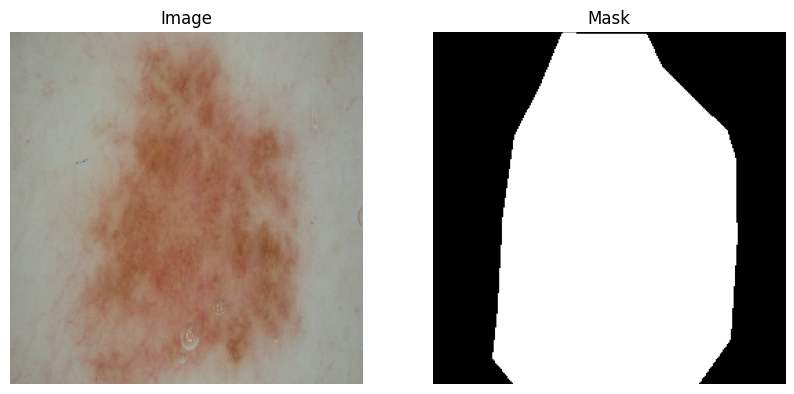

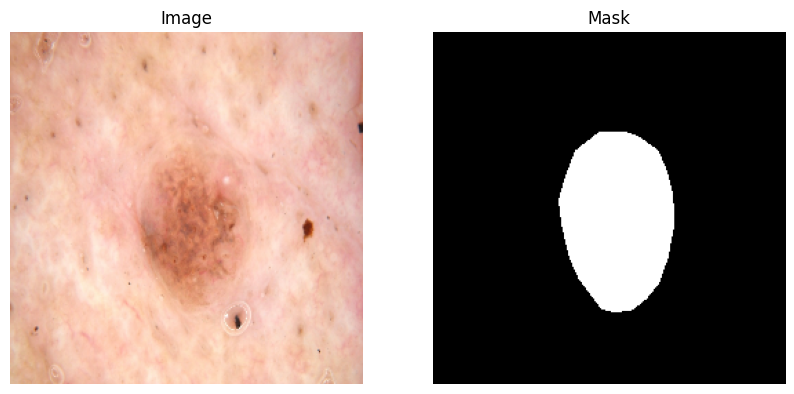

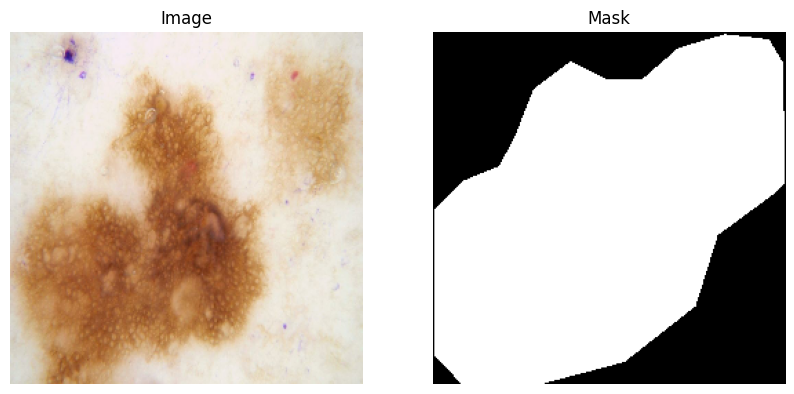

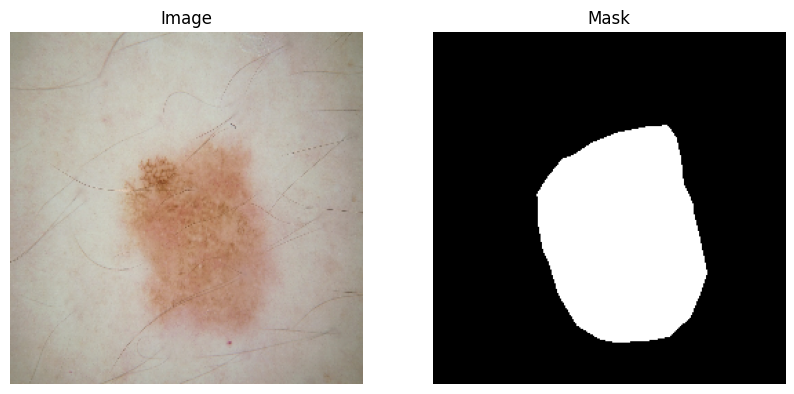

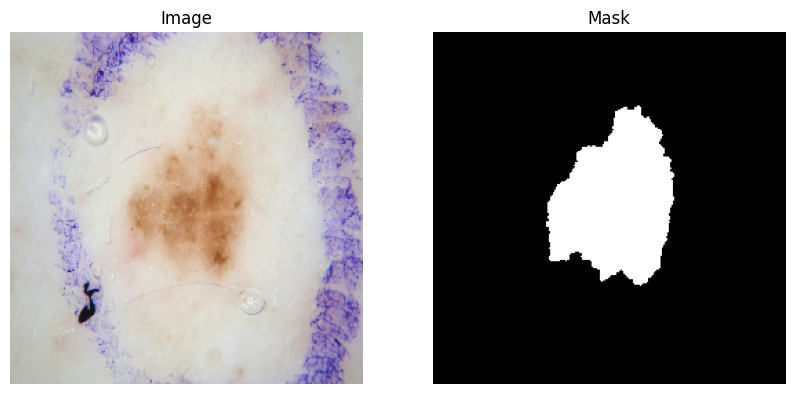

In [ ]:
visualize_dataset(train_dataset, num_samples=5)

In [ ]:
image, mask = next(iter(train_dataset))

print("Shape of the images: ", image.shape)
print("Shape of the masks: ", mask.shape)

print("Min value of the images: ", image.numpy().min())
print("Max value of the images: ", image.numpy().max())

print("Min value of the masks: ", mask.numpy().min())
print("Max value of the masks: ", mask.numpy().max())

Shape of the images:  (8, 256, 256, 3)
Shape of the masks:  (8, 256, 256, 1)
Min value of the images:  0.0
Max value of the images:  1.0
Min value of the masks:  0
Max value of the masks:  1


#### Zoom normalized dataset

Here we define the datasets with the zoom normalized images.

In [15]:
BATCH_SIZE = 8

train_dataset_norm = tf.data.Dataset.from_generator(
    lambda: data_generator(OUT_DIR, train_set, BATCH_SIZE, augmentation=True),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Adjust shape and dtype as needed for images
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8)  # Adjust shape and dtype for masks
    )
)
val_dataset_norm = tf.data.Dataset.from_generator(
    lambda: data_generator(OUT_DIR, validation_set, BATCH_SIZE, augmentation=False),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Adjust shape and dtype as needed for images
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8)  # Adjust shape and dtype for masks
    )
)
test_dataset_norm = tf.data.Dataset.from_generator(
    lambda: data_generator(OUT_DIR, test_set, BATCH_SIZE, augmentation=False),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),  # Adjust shape and dtype as needed for images
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8)  # Adjust shape and dtype for masks
    )
)

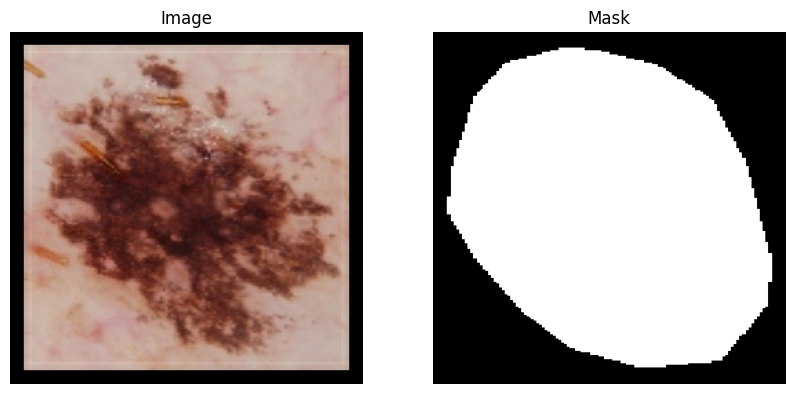

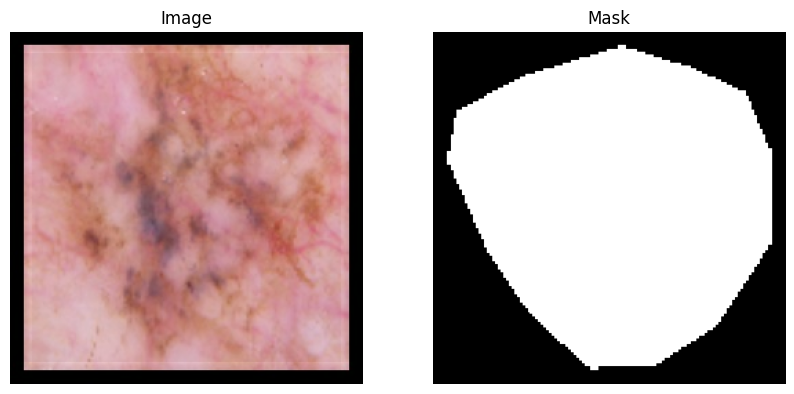

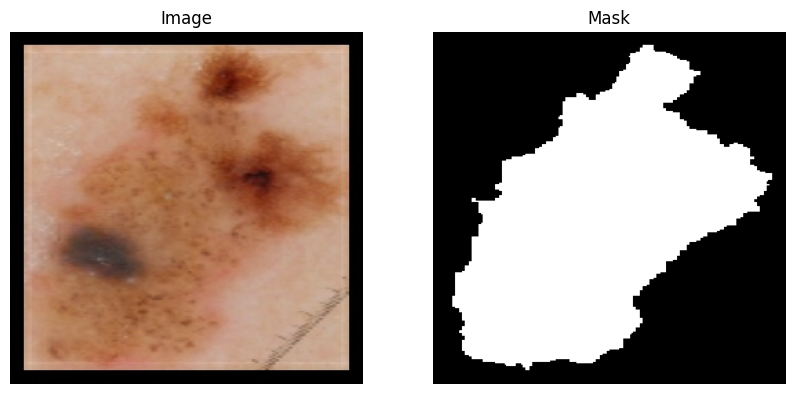

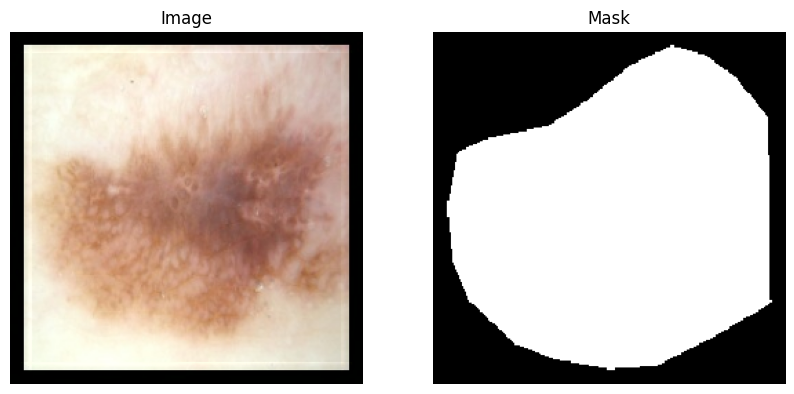

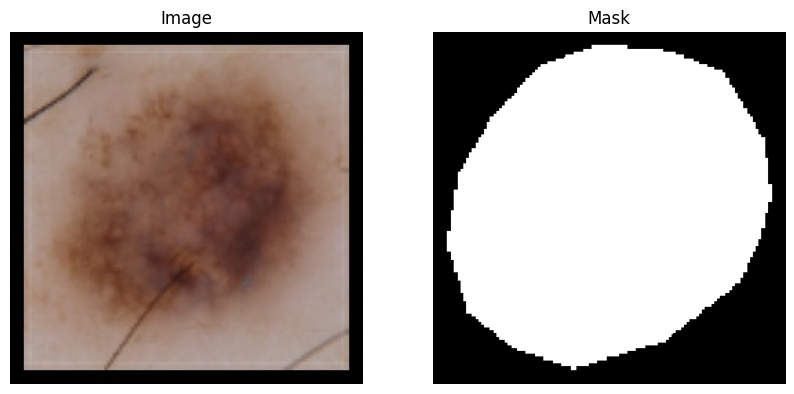

In [ ]:
# Visualize examples from the training dataset
visualize_dataset(train_dataset_norm, num_samples=5)

In [ ]:
image_norm, mask_norm = next(iter(train_dataset_norm))

print("Shape of the images: ", image_norm.shape)
print("Shape of the masks: ", mask_norm.shape)

print("Min value of the images: ", image_norm.numpy().min())
print("Max value of the images: ", image_norm.numpy().max())

print("Min value of the masks: ", mask_norm.numpy().min())
print("Max value of the masks: ", mask_norm.numpy().max())

Shape of the images:  (8, 256, 256, 3)
Shape of the masks:  (8, 256, 256, 1)
Min value of the images:  0.0
Max value of the images:  0.9490197
Min value of the masks:  0
Max value of the masks:  1


## **Models**

In this section we are going to train different models for the task of segmentation of moles.         

We are going to train two variations of the U-Net model with the original and zoom normalized datasets. The models are:    

* U-Net with original data     
* Attention U-Net with original data      
* U-Net with zoom normalized data    
* Attention U-Net with normalized data     

The two **U-Net** and the two Attention U-Net models have the same architectures. In the case of the U-Net we 4 blocks in the encoder part and 4 blocks in the decoder part. We are using residual conections and each block consists of two convolutional layers and the residual conection step.       
In the case of the **Attention U-Net**, we have 5 convolutional blocks in the encoder part and other five in the decoder part with the use of attention gates, as presented in the original paper.      
     
       
\\

U-Net paper: https://arxiv.org/abs/1505.04597     
Attention U-Net paper: https://arxiv.org/abs/1804.03999     

#### U-Net Model - Original data

In [16]:
def unet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(val_dataset))

In [17]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = self.model.predict(test_images)
            pred_masks = (pred_masks >= 0.5).astype(int)
            #pred_masks = tf.math.argmax(pred_masks, axis=-1)
            #pred_masks = pred_masks[..., tf.newaxis]

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(
                f"Predicted Mask: {epoch:03d}",
            )

            plt.show()
            plt.close()

In [18]:
def plot_history(history, out_dir=None):

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  # summarize history for accuracy
  axs[0].plot(history.history['accuracy'])
  axs[0].plot(history.history['val_accuracy'])
  axs[0].set_title('model accuracy')
  axs[0].set_ylabel('accuracy')
  axs[0].set_xlabel('epoch')
  axs[0].legend(['Train', 'Validation'], loc='upper left')

  # summarize history for loss
  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('model loss')
  axs[1].set_ylabel('loss')
  axs[1].set_xlabel('epoch')
  axs[1].legend(['Train', 'Validation'], loc='upper left')

  fig.tight_layout()
  if out_dir is not None:
    fig.savefig(out_dir)

  plt.show()

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_original.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',  # 'min' or 'max' depending on the monitored metric
    save_weights_only=False,  # True to save only model weights, False to save the entire model
    verbose=1  # Verbosity level (0: silent, 1: update messages)
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity level (0: silent, 1: update messages)
    mode='min',  # 'min' or 'max' depending on the monitored metric
    restore_best_weights=True  # Restore model weights to the best checkpoint when training stops
)

In [ ]:
callbacks = [DisplayCallback(5), checkpoint_callback, early_stopping_callback]

Epoch 1/100
1/1 [==============================] - 1s 621ms/step


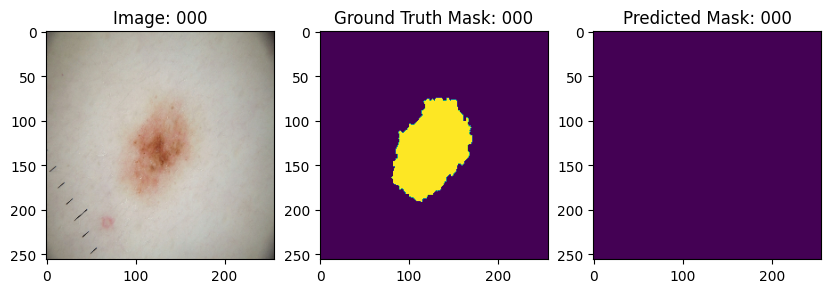


Epoch 1: val_loss did not improve from 0.96525
78/78 [==============================] - 49s 492ms/step - loss: 0.4342 - accuracy: 0.8563 - val_loss: 1.0864 - val_accuracy: 0.7172
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.8869
Epoch 2: val_loss did not improve from 0.96525
78/78 [==============================] - 48s 626ms/step - loss: 0.3108 - accuracy: 0.8869 - val_loss: 1.7464 - val_accuracy: 0.7120
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9016
Epoch 3: val_loss did not improve from 0.96525
78/78 [==============================] - 38s 487ms/step - loss: 0.2586 - accuracy: 0.9016 - val_loss: 2.1597 - val_accuracy: 0.7081
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9088
Epoch 4: val_loss did not improve from 0.96525
78/78 [==============================] - 31s 398ms/step - loss: 0.2397 - accuracy: 0.9088 - val_loss: 2.2930 - val_accuracy: 0.710

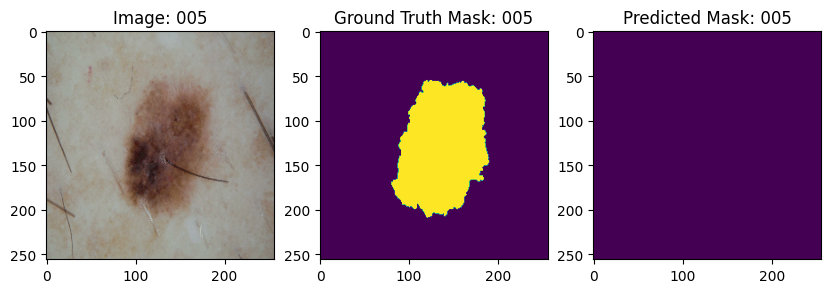


Epoch 6: val_loss did not improve from 0.96525
78/78 [==============================] - 35s 451ms/step - loss: 0.2290 - accuracy: 0.9145 - val_loss: 1.7744 - val_accuracy: 0.7108
Epoch 7/100
78/78 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9181
Epoch 7: val_loss improved from 0.96525 to 0.82817, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_original.h5
78/78 [==============================] - 38s 487ms/step - loss: 0.2157 - accuracy: 0.9181 - val_loss: 0.8282 - val_accuracy: 0.7465
Epoch 8/100
78/78 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9264
Epoch 8: val_loss improved from 0.82817 to 0.40803, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_original.h5
78/78 [==============================] - 49s 630ms/step - loss: 0.1885 - accuracy: 0.9264 - val_loss: 0.4080 - val_accuracy: 0.8583
Epoch 9/100
78/78 [==============================] - ETA: 0s - loss: 0.1835 - 

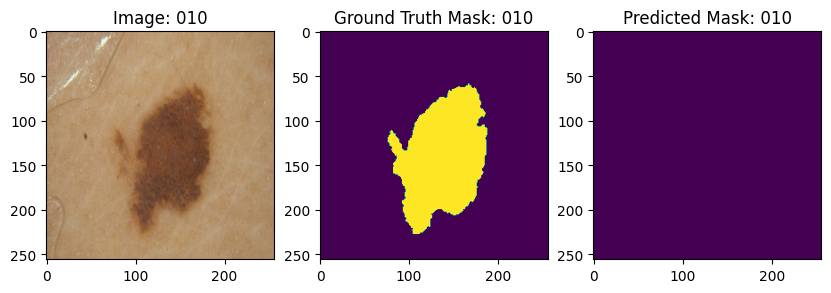


Epoch 11: val_loss did not improve from 0.16563
78/78 [==============================] - 33s 423ms/step - loss: 0.1752 - accuracy: 0.9325 - val_loss: 0.1721 - val_accuracy: 0.9302
Epoch 12/100
78/78 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9350
Epoch 12: val_loss did not improve from 0.16563
78/78 [==============================] - 32s 415ms/step - loss: 0.1709 - accuracy: 0.9350 - val_loss: 0.1703 - val_accuracy: 0.9313
Epoch 13/100
78/78 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9358
Epoch 13: val_loss did not improve from 0.16563
78/78 [==============================] - 31s 398ms/step - loss: 0.1660 - accuracy: 0.9358 - val_loss: 0.1708 - val_accuracy: 0.9326
Epoch 14/100
78/78 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9364
Epoch 14: val_loss improved from 0.16563 to 0.15547, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_original.h5
78/78 [===================

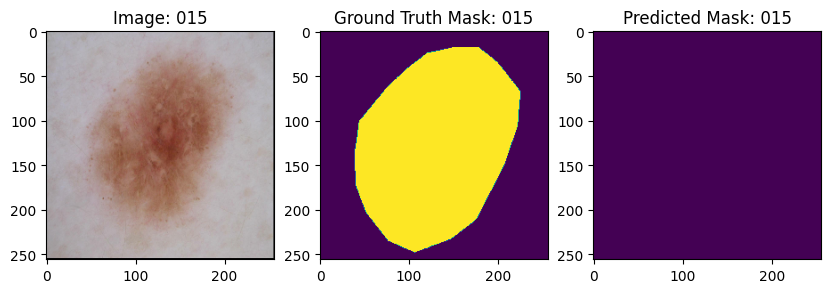


Epoch 16: val_loss improved from 0.15547 to 0.14482, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_original.h5
78/78 [==============================] - 43s 560ms/step - loss: 0.1487 - accuracy: 0.9415 - val_loss: 0.1448 - val_accuracy: 0.9412
Epoch 17/100
78/78 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9468
Epoch 17: val_loss did not improve from 0.14482
78/78 [==============================] - 36s 468ms/step - loss: 0.1367 - accuracy: 0.9468 - val_loss: 0.1638 - val_accuracy: 0.9337
Epoch 18/100
78/78 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9427
Epoch 18: val_loss did not improve from 0.14482
78/78 [==============================] - 31s 398ms/step - loss: 0.1455 - accuracy: 0.9427 - val_loss: 0.1488 - val_accuracy: 0.9383
Epoch 19/100
78/78 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9407
Epoch 19: val_loss did not improve from 0.14482
78/78 [===================

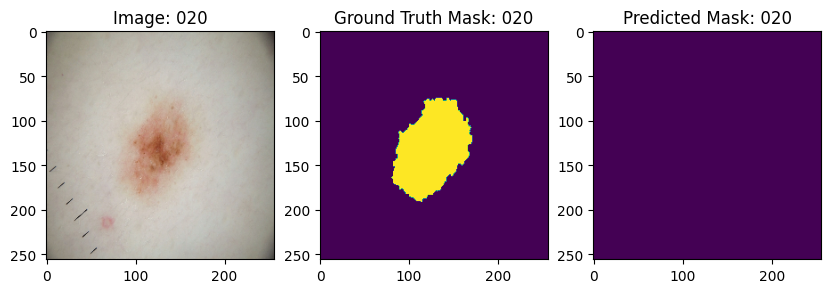


Epoch 21: val_loss did not improve from 0.14482
78/78 [==============================] - 36s 461ms/step - loss: 0.1214 - accuracy: 0.9519 - val_loss: 0.1621 - val_accuracy: 0.9368
Epoch 22/100
78/78 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9459
Epoch 22: val_loss did not improve from 0.14482
78/78 [==============================] - 36s 463ms/step - loss: 0.1349 - accuracy: 0.9459 - val_loss: 0.1534 - val_accuracy: 0.9400
Epoch 23/100
78/78 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9499
Epoch 23: val_loss did not improve from 0.14482
78/78 [==============================] - 27s 352ms/step - loss: 0.1262 - accuracy: 0.9499 - val_loss: 0.1722 - val_accuracy: 0.9327
Epoch 24/100
78/78 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9482
Epoch 24: val_loss did not improve from 0.14482
78/78 [==============================] - 32s 409ms/step - loss: 0.1312 - accuracy: 0.9482 - val_loss: 0.1499 - val_accuracy

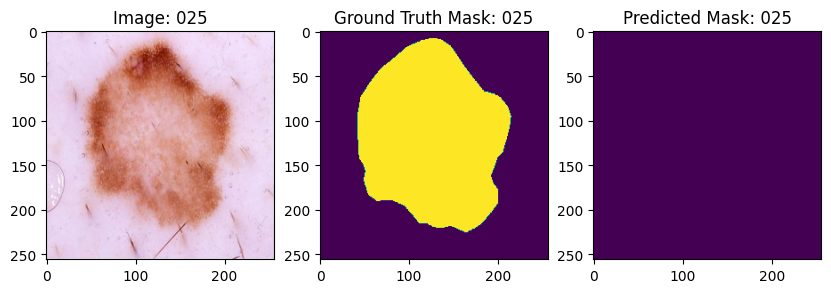


Epoch 26: val_loss did not improve from 0.14482
Restoring model weights from the end of the best epoch: 16.
78/78 [==============================] - 38s 485ms/step - loss: 0.1202 - accuracy: 0.9523 - val_loss: 0.1549 - val_accuracy: 0.9365
Epoch 26: early stopping


In [ ]:
LEARNING_RATE = 1e-4
NUM_CLASSES = 1
EPOCHS = 100

# Build model
model_unet_original = unet(img_size=(IMG_HEIGHT, IMG_WIDTH), num_classes=NUM_CLASSES)

model_unet_original.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history_unet_original = model_unet_original.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    steps_per_epoch = len(train_set) // BATCH_SIZE,
    validation_steps = len(validation_set) // BATCH_SIZE
)

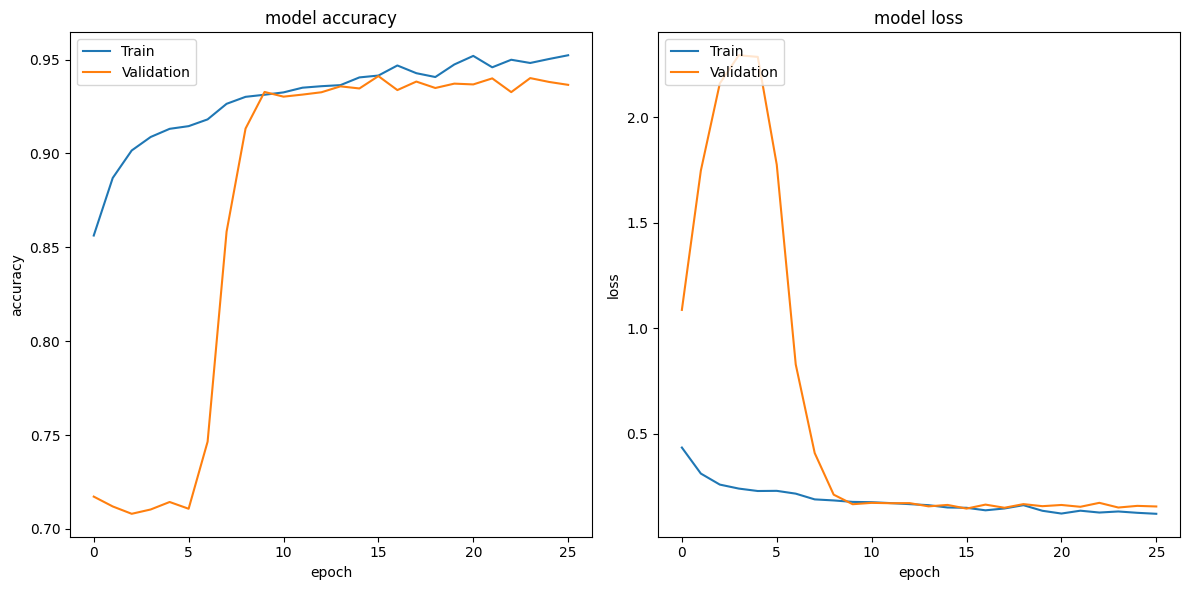

In [ ]:
plot_history(history_unet_original, out_dir='/content/drive/MyDrive/DLMIA/Practical_Block_1/results/unet_original/unet_original.png')

Prediction of some examples of the validation set.

In [20]:
def plot_results(images, masks, predictions):

  fig, axs = plt.subplots(4, 3, figsize=(8,16))
  for i in range(4):
    axs[i,0].imshow(images[i])
    axs[i,0].axis('off')
    axs[i,0].set_title('Image')

    axs[i,1].imshow(masks[i], cmap='gray')
    axs[i,1].axis('off')
    axs[i,1].set_title('Original')

    axs[i,2].imshow(predictions[i], cmap='gray')
    axs[i,2].axis('off')
    axs[i,2].set_title('Predicted')

  fig.tight_layout()
  plt.show()

1/1 [==============================] - 0s 41ms/step


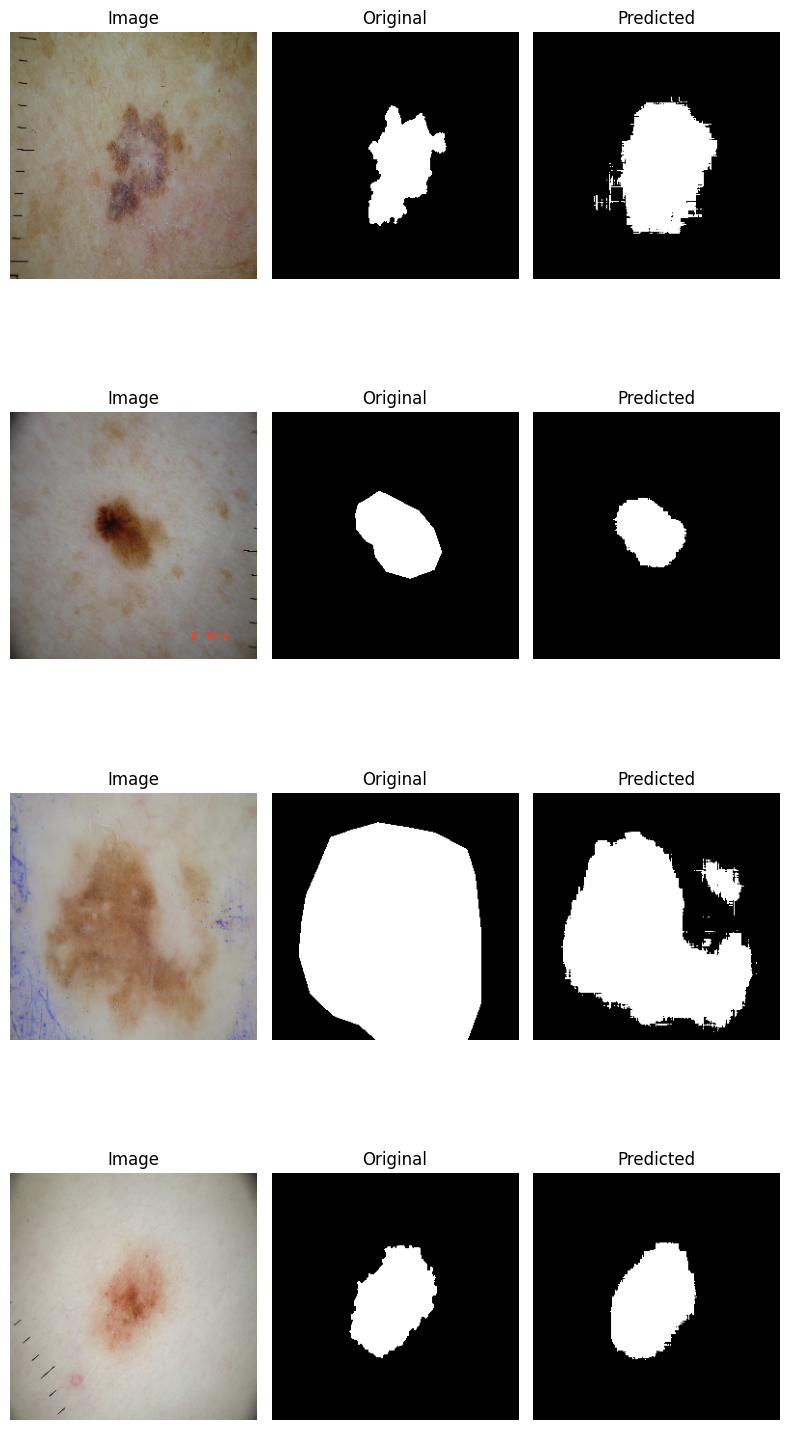

In [ ]:
val_images, val_masks = next(iter(val_dataset))

pred_masks = model_unet_original.predict(val_images)
pred_masks = (pred_masks >= 0.5).astype(int)

plot_results(val_images, val_masks, pred_masks)

#### Attention U-Net - Original data

In [21]:
from keras import models, layers, regularizers
from keras import backend as K


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_original.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',  # 'min' or 'max' depending on the monitored metric
    save_weights_only=False,  # True to save only model weights, False to save the entire model
    verbose=1  # Verbosity level (0: silent, 1: update messages)
)

callbacks = [DisplayCallback(5), checkpoint_callback, early_stopping_callback]

In [ ]:
LEARNING_RATE = 1e-4
NUM_CLASSES = 1
EPOCHS = 100

# Build model
model_attention_original = Attention_UNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES=NUM_CLASSES)

model_attention_original.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history_attention_original = model_attention_original.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    steps_per_epoch = len(train_set) // BATCH_SIZE,
    validation_steps = len(validation_set) // BATCH_SIZE
)

Output hidden; open in https://colab.research.google.com to view.

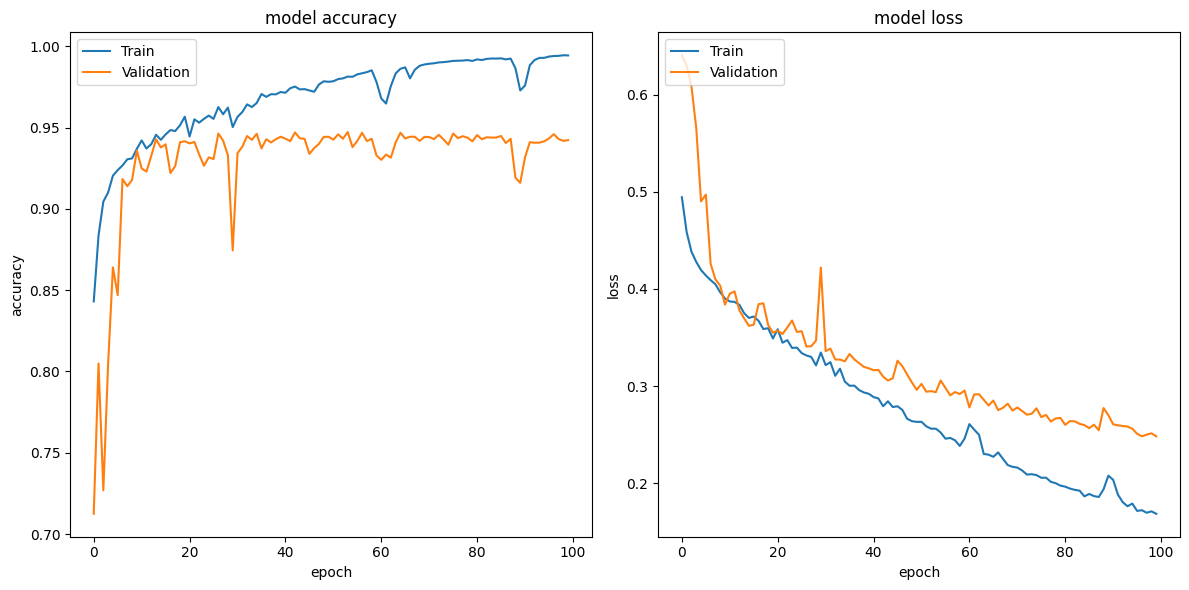

In [ ]:
plot_history(history_attention_original, out_dir='/content/drive/MyDrive/DLMIA/Practical_Block_1/results/attention_original/attention_original.png')

Prediction of some examples of the validation set.

1/1 [==============================] - 0s 28ms/step


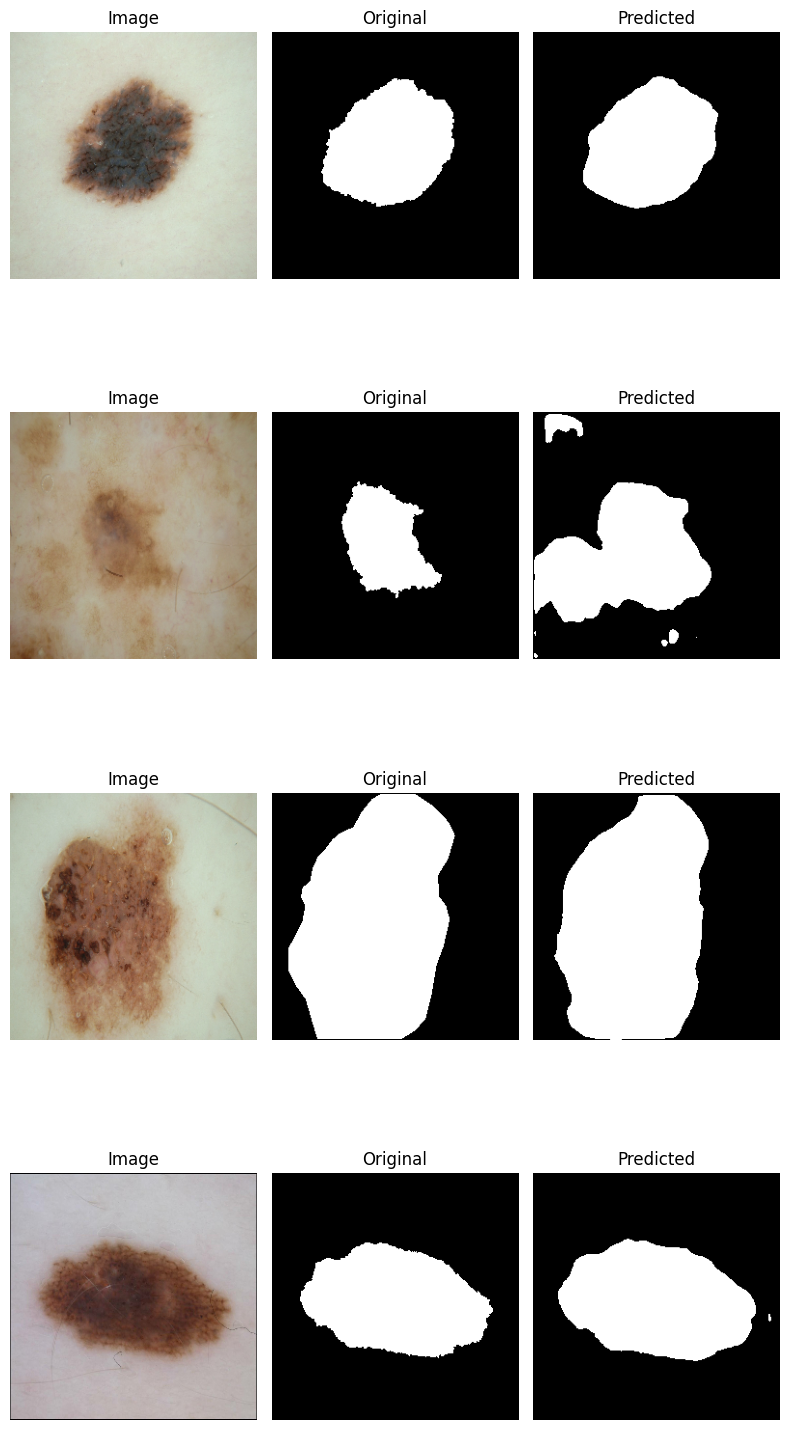

In [ ]:
val_images, val_masks = next(iter(val_dataset))

pred_masks = model_attention_original.predict(val_images)
pred_masks = (pred_masks >= 0.5).astype(int)

plot_results(val_images, val_masks, pred_masks)

#### U-Net Model - Zoom Normalized data

In [ ]:
test_images, test_masks = next(iter(val_dataset_norm))

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',  # 'min' or 'max' depending on the monitored metric
    save_weights_only=False,  # True to save only model weights, False to save the entire model
    verbose=1  # Verbosity level (0: silent, 1: update messages)
)

callbacks = [DisplayCallback(5), checkpoint_callback, early_stopping_callback]

Epoch 1/100
1/1 [==============================] - 0s 446ms/step


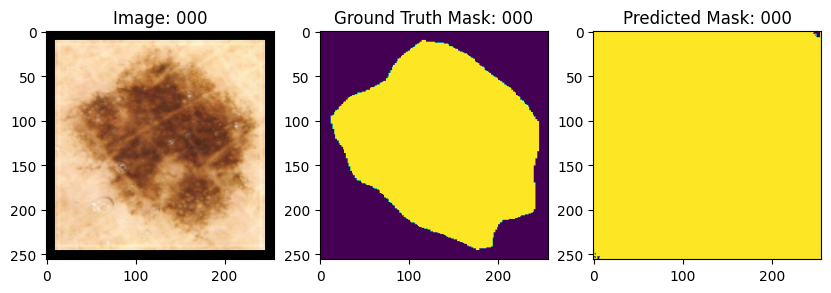


Epoch 1: val_loss improved from inf to 1.02434, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 674s 9s/step - loss: 0.3113 - accuracy: 0.8861 - val_loss: 1.0243 - val_accuracy: 0.5889
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9063
Epoch 2: val_loss did not improve from 1.02434
78/78 [==============================] - 15s 189ms/step - loss: 0.2177 - accuracy: 0.9063 - val_loss: 1.2739 - val_accuracy: 0.5923
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9152
Epoch 3: val_loss did not improve from 1.02434
78/78 [==============================] - 15s 188ms/step - loss: 0.1956 - accuracy: 0.9152 - val_loss: 1.5980 - val_accuracy: 0.5903
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9197
Epoch 4: val_loss did not improve from 1.02434
78/78 [==============================] - 14s 185ms/step - loss: 0.1846 - accuracy: 0.9197 - val_loss: 1.4330 - val_accuracy: 0.5920
Epoch 5/100
78/78 [=============================

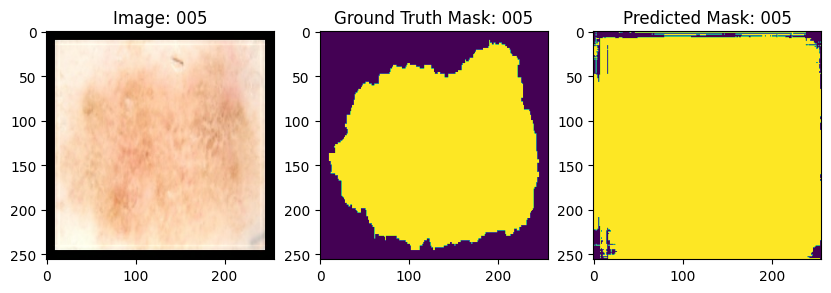


Epoch 6: val_loss did not improve from 1.02434
78/78 [==============================] - 15s 198ms/step - loss: 0.1721 - accuracy: 0.9245 - val_loss: 1.0443 - val_accuracy: 0.6063
Epoch 7/100
78/78 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9264
Epoch 7: val_loss improved from 1.02434 to 0.53930, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5
78/78 [==============================] - 17s 220ms/step - loss: 0.1678 - accuracy: 0.9264 - val_loss: 0.5393 - val_accuracy: 0.7591
Epoch 8/100
78/78 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9251
Epoch 8: val_loss improved from 0.53930 to 0.24322, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5
78/78 [==============================] - 17s 221ms/step - loss: 0.1706 - accuracy: 0.9251 - val_loss: 0.2432 - val_accuracy: 0.8904
Epoch 9/100
78/78 [==============================] - ETA: 0s - loss: 0.1660 - accuracy

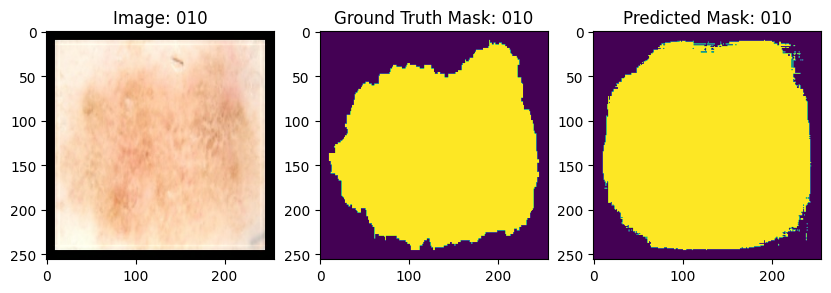


Epoch 11: val_loss did not improve from 0.18098
78/78 [==============================] - 15s 194ms/step - loss: 0.1583 - accuracy: 0.9306 - val_loss: 0.1935 - val_accuracy: 0.9145
Epoch 12/100
78/78 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9352
Epoch 12: val_loss improved from 0.18098 to 0.18068, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5
78/78 [==============================] - 18s 229ms/step - loss: 0.1494 - accuracy: 0.9352 - val_loss: 0.1807 - val_accuracy: 0.9227
Epoch 13/100
78/78 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9326
Epoch 13: val_loss improved from 0.18068 to 0.17685, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5
78/78 [==============================] - 17s 217ms/step - loss: 0.1539 - accuracy: 0.9326 - val_loss: 0.1768 - val_accuracy: 0.9225
Epoch 14/100
78/78 [==============================] - ETA: 0s - loss: 0.1499 - ac

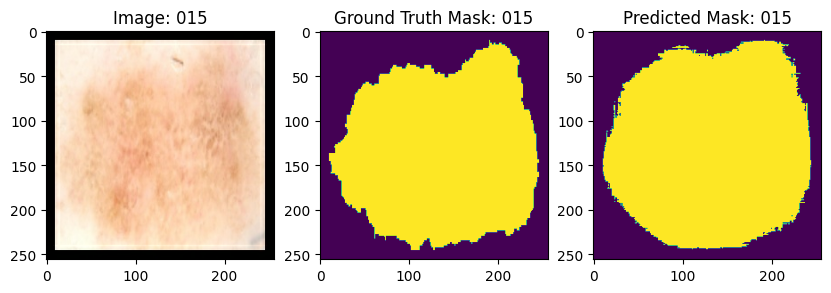


Epoch 16: val_loss did not improve from 0.17240
78/78 [==============================] - 15s 194ms/step - loss: 0.1418 - accuracy: 0.9382 - val_loss: 0.1728 - val_accuracy: 0.9248
Epoch 17/100
78/78 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9378
Epoch 17: val_loss did not improve from 0.17240
78/78 [==============================] - 15s 189ms/step - loss: 0.1425 - accuracy: 0.9378 - val_loss: 0.1754 - val_accuracy: 0.9247
Epoch 18/100
78/78 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9406
Epoch 18: val_loss did not improve from 0.17240
78/78 [==============================] - 15s 190ms/step - loss: 0.1361 - accuracy: 0.9406 - val_loss: 0.1751 - val_accuracy: 0.9249
Epoch 19/100
78/78 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9403
Epoch 19: val_loss did not improve from 0.17240
78/78 [==============================] - 15s 196ms/step - loss: 0.1378 - accuracy: 0.9403 - val_loss: 0.1861 - val_accuracy

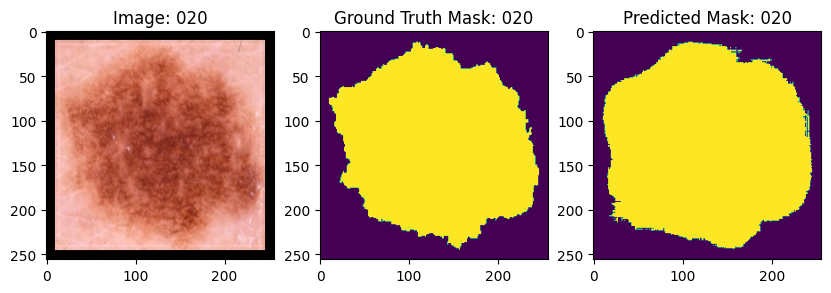


Epoch 21: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 191ms/step - loss: 0.1327 - accuracy: 0.9420 - val_loss: 0.1931 - val_accuracy: 0.9193
Epoch 22/100
78/78 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9422
Epoch 22: val_loss did not improve from 0.16366
78/78 [==============================] - 14s 187ms/step - loss: 0.1324 - accuracy: 0.9422 - val_loss: 0.1704 - val_accuracy: 0.9279
Epoch 23/100
78/78 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9438
Epoch 23: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 192ms/step - loss: 0.1288 - accuracy: 0.9438 - val_loss: 0.1750 - val_accuracy: 0.9246
Epoch 24/100
78/78 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9462
Epoch 24: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 191ms/step - loss: 0.1240 - accuracy: 0.9462 - val_loss: 0.1805 - val_accuracy

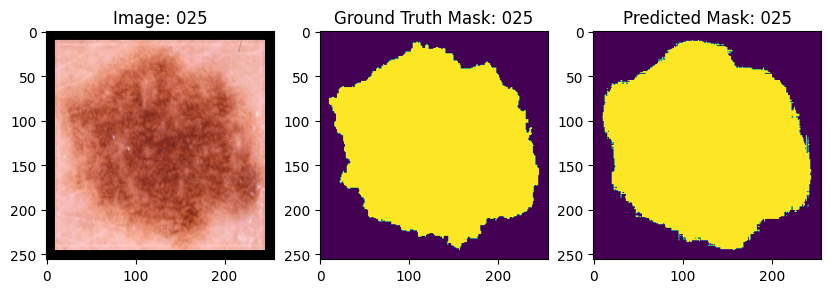


Epoch 26: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 199ms/step - loss: 0.1249 - accuracy: 0.9458 - val_loss: 0.1741 - val_accuracy: 0.9253
Epoch 27/100
78/78 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9491
Epoch 27: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 192ms/step - loss: 0.1176 - accuracy: 0.9491 - val_loss: 0.1821 - val_accuracy: 0.9238
Epoch 28/100
78/78 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9494
Epoch 28: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 192ms/step - loss: 0.1166 - accuracy: 0.9494 - val_loss: 0.1814 - val_accuracy: 0.9250
Epoch 29/100
78/78 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9501
Epoch 29: val_loss did not improve from 0.16366
78/78 [==============================] - 15s 195ms/step - loss: 0.1153 - accuracy: 0.9501 - val_loss: 0.1886 - val_accuracy

In [ ]:
LEARNING_RATE = 1e-4
NUM_CLASSES = 1
EPOCHS = 100

# Build model
model_unet_norm = unet(img_size=(IMG_HEIGHT, IMG_WIDTH), num_classes=NUM_CLASSES)

model_unet_norm.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history_unet_norm = model_unet_norm.fit(
    train_dataset_norm,
    epochs=EPOCHS,
    validation_data=val_dataset_norm,
    callbacks=callbacks,
    steps_per_epoch = len(train_set) // BATCH_SIZE,
    validation_steps = len(validation_set) // BATCH_SIZE
)

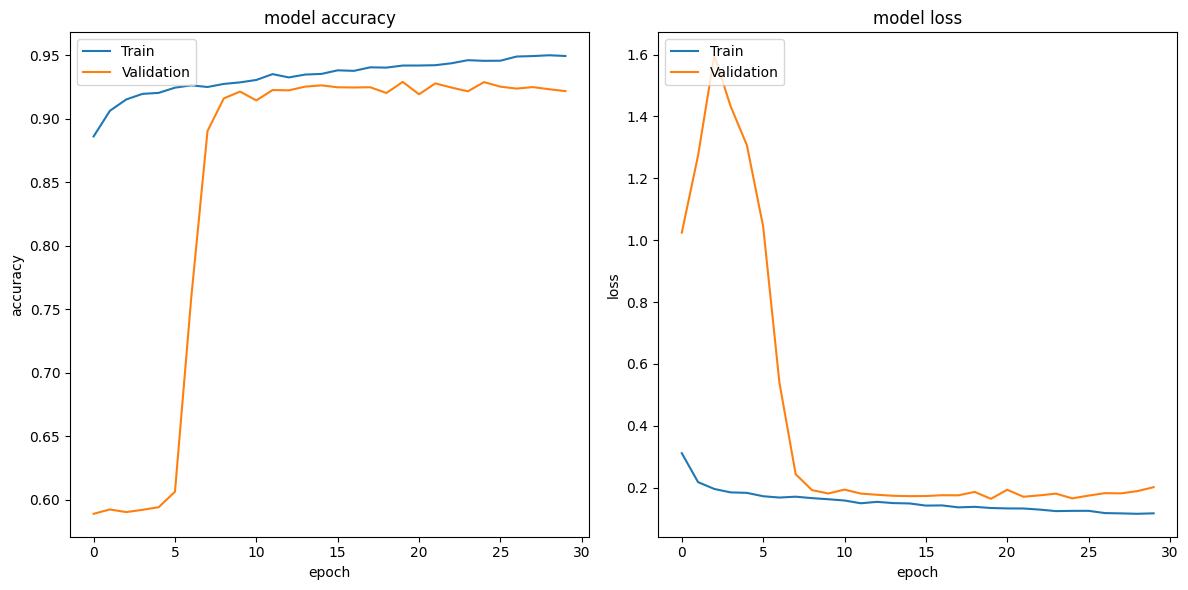

In [ ]:
plot_history(history_unet_norm, out_dir='/content/drive/MyDrive/DLMIA/Practical_Block_1/results/unet_norm/unet_norm.png')

Prediction of some examples of the validation set.

1/1 [==============================] - 0s 25ms/step


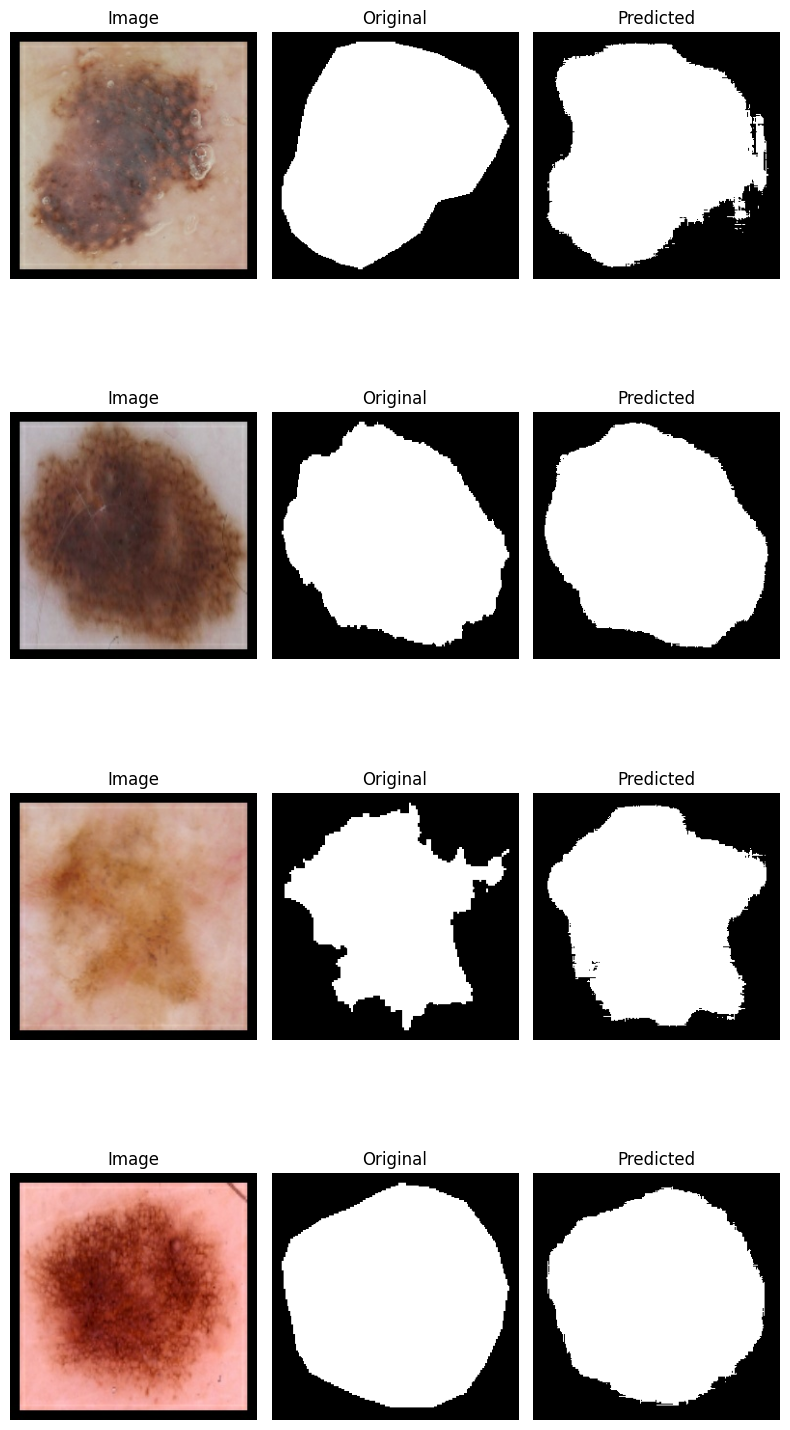

In [ ]:
val_images, val_masks = next(iter(val_dataset_norm))

pred_masks = model_unet_norm.predict(val_images)
pred_masks = (pred_masks >= 0.5).astype(int)

plot_results(val_images, val_masks, pred_masks)

#### Attention U-Net - Zoom Normalized data

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_norm.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',  # 'min' or 'max' depending on the monitored metric
    save_weights_only=False,  # True to save only model weights, False to save the entire model
    verbose=1  # Verbosity level (0: silent, 1: update messages)
)

callbacks = [DisplayCallback(5), checkpoint_callback, early_stopping_callback]

Epoch 1/100
1/1 [==============================] - 2s 2s/step


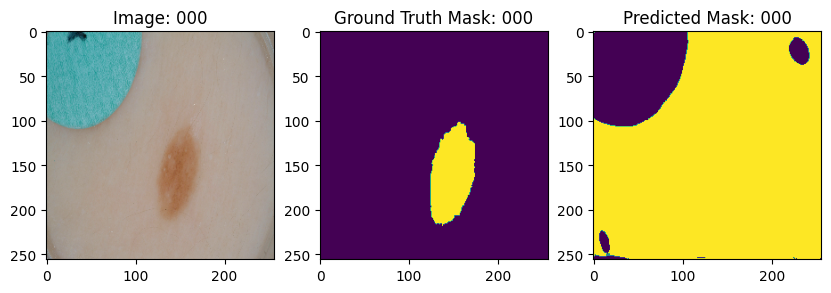


Epoch 1: val_loss improved from inf to 0.29895, saving model to /content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_norm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 664s 8s/step - loss: 0.3268 - accuracy: 0.9386 - val_loss: 0.2990 - val_accuracy: 0.9414
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.9420
Epoch 2: val_loss did not improve from 0.29895
78/78 [==============================] - 86s 879ms/step - loss: 0.3222 - accuracy: 0.9420 - val_loss: 0.3335 - val_accuracy: 0.9119
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.9437
Epoch 3: val_loss did not improve from 0.29895
78/78 [==============================] - 66s 843ms/step - loss: 0.3186 - accuracy: 0.9437 - val_loss: 0.3133 - val_accuracy: 0.9413
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.9431
Epoch 4: val_loss did not improve from 0.29895
78/78 [==============================] - 65s 831ms/step - loss: 0.3172 - accuracy: 0.9431 - val_loss: 0.3123 - val_accuracy: 0.9410
Epoch 5/100
78/78 [=============================

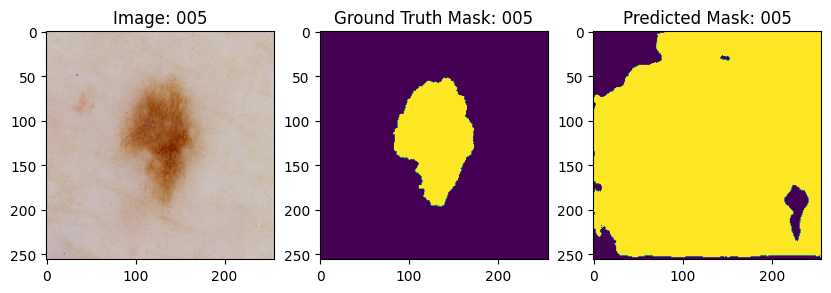


Epoch 6: val_loss did not improve from 0.29895
78/78 [==============================] - 65s 830ms/step - loss: 0.3115 - accuracy: 0.9455 - val_loss: 0.3073 - val_accuracy: 0.9402
Epoch 7/100
78/78 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.9485
Epoch 7: val_loss did not improve from 0.29895
78/78 [==============================] - 64s 820ms/step - loss: 0.3071 - accuracy: 0.9485 - val_loss: 0.3027 - val_accuracy: 0.9447
Epoch 8/100
78/78 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.9489
Epoch 8: val_loss did not improve from 0.29895
78/78 [==============================] - 63s 802ms/step - loss: 0.3047 - accuracy: 0.9489 - val_loss: 0.3208 - val_accuracy: 0.9293
Epoch 9/100
78/78 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.9505
Epoch 9: val_loss did not improve from 0.29895
78/78 [==============================] - 66s 845ms/step - loss: 0.3017 - accuracy: 0.9505 - val_loss: 0.3074 - val_accuracy: 0.938

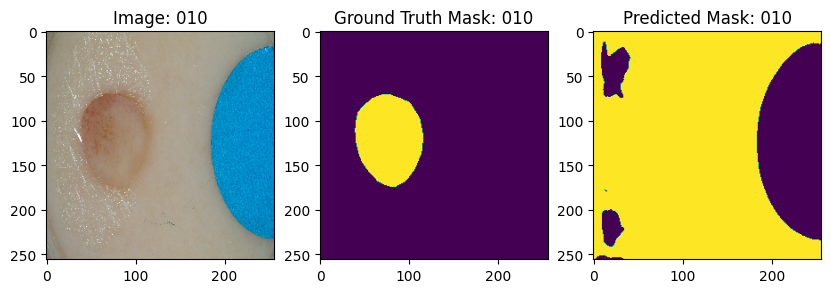


Epoch 11: val_loss did not improve from 0.29895
Restoring model weights from the end of the best epoch: 1.
78/78 [==============================] - 64s 818ms/step - loss: 0.2942 - accuracy: 0.9548 - val_loss: 0.3017 - val_accuracy: 0.9431
Epoch 11: early stopping


In [ ]:
LEARNING_RATE = 1e-4
NUM_CLASSES = 1
EPOCHS = 100

# Build model
model_attention_norm = Attention_UNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES=NUM_CLASSES)

model_attention_norm.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model_attention_norm.load_weights('/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_norm.h5')

# Train the model, doing validation at the end of each epoch.
history_attention_norm = model_attention_norm.fit(
    train_dataset_norm,
    epochs=EPOCHS,
    validation_data=val_dataset_norm,
    callbacks=callbacks,
    steps_per_epoch = len(train_set) // BATCH_SIZE,
    validation_steps = len(validation_set) // BATCH_SIZE
)

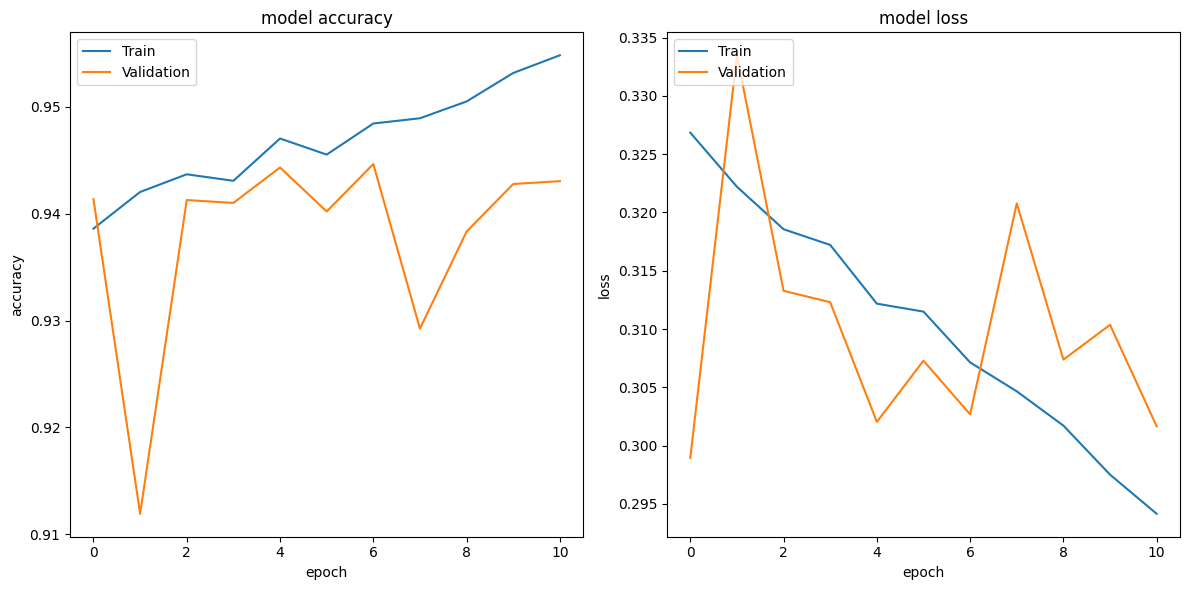

In [ ]:
plot_history(history_attention_norm, out_dir='/content/drive/MyDrive/DLMIA/Practical_Block_1/results/attention_norm/attention_norm.png')

Prediction of some examples of the validation set.

1/1 [==============================] - 0s 27ms/step


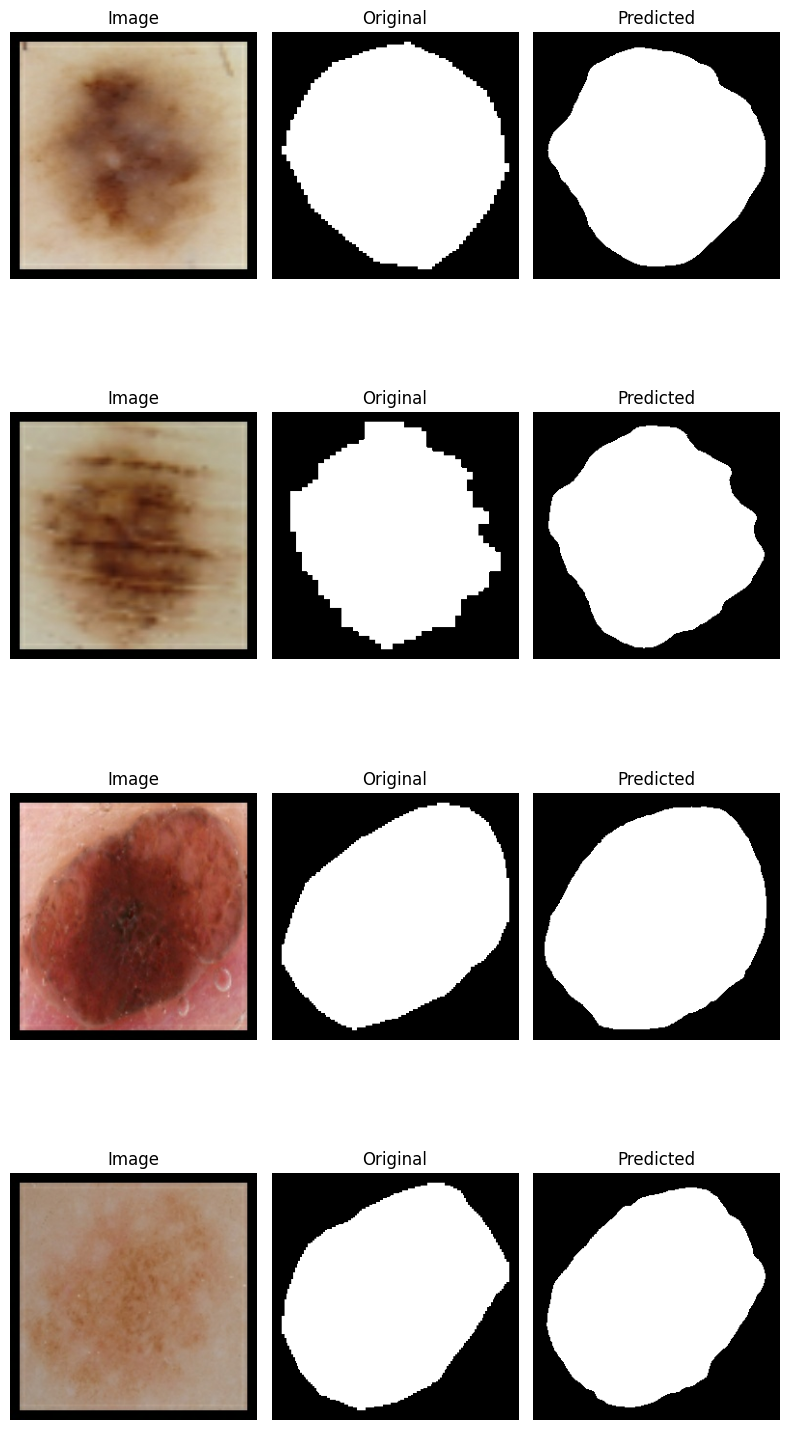

In [ ]:
val_images, val_masks = next(iter(val_dataset_norm))

pred_masks = model_attention_norm.predict(val_images)
pred_masks = (pred_masks >= 0.5).astype(int)

plot_results(val_images, val_masks, pred_masks)

## **Comparison of the models**

The metrics used to evaluate the performance of the models are the ones presented in the original challenge. These metrics are:     
* Accuracy   
* Sensitivity    
* Specificity    
* F1 score   
* Dice coefficient   
* Jaccard Index    
* ROC curve   

In [22]:
def binary_mask_metrics(ground_truth, predicted):
    # Ensure both masks are of the same shape
    if ground_truth.shape != predicted.shape:
        raise ValueError("Ground truth and predicted masks must have the same shape.")

    ground_truth = tf.cast(ground_truth, dtype=tf.int64)
    predicted = tf.cast(predicted, dtype=tf.int64)

    # Calculate True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
    ground_truth = tf.reshape(ground_truth, [-1])
    predicted = tf.reshape(predicted, [-1])

    tp = tf.reduce_sum(ground_truth * predicted).numpy()
    tn = tf.reduce_sum((1 - ground_truth) * (1 - predicted)).numpy()
    fp = tf.reduce_sum((1 - ground_truth) * predicted).numpy()
    fn = tf.reduce_sum(ground_truth * (1 - predicted)).numpy()

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)

    # Specificity
    specificity = tn / (tn + fp)

    # F1 Score
    f1 = 2 * (tp / (2 * tp + fp + fn))

    # Dice Coefficient
    dice = (2 * tp) / (2 * tp + fp + fn)

    # Jaccard Index (Intersection over Union)
    jaccard = tp / (tp + fp + fn)

    # ROC Curve
    fpr, tpr, _ = roc_curve(ground_truth.numpy(), predicted.numpy())
    roc_auc = auc(fpr, tpr)

    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "F1 Score": f1,
        "Dice Coefficient": dice,
        "Jaccard Index": jaccard,
        "ROC AUC": roc_auc
    }

Import the checkpoints of the model in order to evaluate the performance of them in the validation set.

In [ ]:
NUM_CLASSES = 1
LEARNING_RATE = 1e-4

# U-Net with original data
model_unet_original = unet(img_size=(IMG_HEIGHT, IMG_WIDTH), num_classes=NUM_CLASSES)
model_unet_original.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_unet_original.load_weights('/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_original.h5')


# Attention U-Net with original data
model_attention_original = Attention_UNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES=NUM_CLASSES)
model_attention_original.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_attention_original.load_weights('/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_original.h5')


# U-Net with zoom normalized data
model_unet_norm = unet(img_size=(IMG_HEIGHT, IMG_WIDTH), num_classes=NUM_CLASSES)
model_unet_norm.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_unet_norm.load_weights('/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/unet_norm.h5')


# Attention U-Net with zoom normalized data
model_attention_norm = Attention_UNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES=NUM_CLASSES)
model_attention_norm.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_attention_norm.load_weights('/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_norm.h5')

11/11 [==============================] - 3s 264ms/step


In [ ]:
results_unet_original = []
results_attention_original = []
results_unet_norm = []
results_attention_norm = []

for i in tqdm(range(len(validation_set) // BATCH_SIZE)):
  image, mask = next(iter(val_dataset))
  image_norm, mask_norm = next(iter(val_dataset_norm))

  pred_unet_original = model_unet_original.predict(image, verbose=0)
  pred_unet_original = (pred_unet_original >= 0.5).astype(int)

  pred_attention_original = model_attention_original.predict(image, verbose=0)
  pred_attention_original = (pred_attention_original >= 0.5).astype(int)

  pred_unet_norm = model_unet_norm.predict(image_norm, verbose=0)
  pred_unet_norm = (pred_unet_norm >= 0.5).astype(int)

  pred_attention_norm = model_attention_norm.predict(image_norm, verbose=0)
  pred_attention_norm = (pred_attention_norm >= 0.5).astype(int)

  for j in range(mask.shape[0]):
    results_unet_original.append(binary_mask_metrics(mask[j], pred_unet_original[j]))
    results_attention_original.append(binary_mask_metrics(mask[j], pred_attention_original[j]))
    results_unet_norm.append(binary_mask_metrics(mask_norm[j], pred_unet_norm[j]))
    results_attention_norm.append(binary_mask_metrics(mask_norm[j], pred_attention_norm[j]))

100%|██████████| 11/11 [00:22<00:00,  2.04s/it]


In [ ]:
# Initialize a dictionary to store the mean values
mean_dict_unet_original = {}
mean_dict_attention_original = {}
mean_dict_unet_morm = {}
mean_dict_attention_norm = {}

# U-Net Original
for d in results_unet_original:
    for key, value in d.items():
        if key in mean_dict_unet_original:
            mean_dict_unet_original[key] += value
        else:
            mean_dict_unet_original[key] = value

num_dicts = len(results_unet_original)
for key in mean_dict_unet_original:
    mean_dict_unet_original[key] /= num_dicts

# Attention U-Net Original
for d in results_attention_original:
    for key, value in d.items():
        if key in mean_dict_attention_original:
            mean_dict_attention_original[key] += value
        else:
            mean_dict_attention_original[key] = value

num_dicts = len(results_attention_original)
for key in mean_dict_attention_original:
    mean_dict_attention_original[key] /= num_dicts

# U-Net Normalized
for d in results_unet_norm:
    for key, value in d.items():
        if key in mean_dict_unet_morm:
            mean_dict_unet_morm[key] += value
        else:
            mean_dict_unet_morm[key] = value

num_dicts = len(results_unet_norm)
for key in mean_dict_unet_morm:
    mean_dict_unet_morm[key] /= num_dicts

# Attention U-Net Normalized
for d in results_attention_norm:
    for key, value in d.items():
        if key in mean_dict_attention_norm:
            mean_dict_attention_norm[key] += value
        else:
            mean_dict_attention_norm[key] = value

num_dicts = len(results_attention_norm)
for key in mean_dict_attention_norm:
    mean_dict_attention_norm[key] /= num_dicts


print(mean_dict_unet_original)
print(mean_dict_attention_original)
print(mean_dict_unet_morm)
print(mean_dict_attention_norm)

{'Accuracy': 0.9557065096768466, 'Sensitivity': 0.9302212540761353, 'Specificity': 0.9577945724397222, 'F1 Score': 0.9108860381857184, 'Dice Coefficient': 0.9108860381857184, 'Jaccard Index': 0.8421737417820633, 'ROC AUC': 0.9440079132579284}
{'Accuracy': 0.9799043482000177, 'Sensitivity': 0.9623247564230862, 'Specificity': 0.9845726831485824, 'F1 Score': 0.9585843861180734, 'Dice Coefficient': 0.9585843861180734, 'Jaccard Index': 0.9269620163949793, 'ROC AUC': 0.973448719785834}
{'Accuracy': 0.9440652673894708, 'Sensitivity': 0.9617704976728576, 'Specificity': 0.9271085176038931, 'F1 Score': 0.9525359219579671, 'Dice Coefficient': 0.9525359219579671, 'Jaccard Index': 0.9108185947566302, 'ROC AUC': 0.9444395076383759}
{'Accuracy': 0.9462061795321378, 'Sensitivity': 0.9535831104177862, 'Specificity': 0.9426330560649635, 'F1 Score': 0.9536103891156666, 'Dice Coefficient': 0.9536103891156666, 'Jaccard Index': 0.9126746150951075, 'ROC AUC': 0.9481080832413749}


In [ ]:
# Define row names
row_names = ['U-Net Original', 'Attention U-Net Original', 'U-Net Normalized', 'Attention U-Net Normalized']

df_results = pd.DataFrame([mean_dict_unet_original, mean_dict_attention_original, mean_dict_unet_morm, mean_dict_attention_norm], index=row_names)
df_results

Accuracy  Sensitivity  Specificity  F1 Score  \
U-Net Original              0.955707     0.930221     0.957795  0.910886   
Attention U-Net Original    0.979904     0.962325     0.984573  0.958584   
U-Net Normalized            0.944065     0.961770     0.927109  0.952536   
Attention U-Net Normalized  0.946206     0.953583     0.942633  0.953610   

                            Dice Coefficient  Jaccard Index   ROC AUC  
U-Net Original                      0.910886       0.842174  0.944008  
Attention U-Net Original            0.958584       0.926962  0.973449  
U-Net Normalized                    0.952536       0.910819  0.944440  
Attention U-Net Normalized          0.953610       0.912675  0.948108

In this table we can see the average values of each of the metrics for the different models trained in this practical exercise. The model that obtained a better performance for all the metrics is the **Attention U-Net with Original data**. The metric used in the original challenge to define the ranking table is the Jaccard Index so, for this task, we can say that it is the most important metric. In this case, this model clearly scores the best compared to the other models.

If we compare the performance of the U-Net models with and without zoom normalization we can see that in this case the normalization improved the performance of the model, which indicates that it is useful.

## **Predictions of the test set**

Now, with the selected model (Attention U-Net with Original data), we can make predictions in the test set and obtain the final estimation of the metrics.

1/1 [==============================] - 18s 18s/step


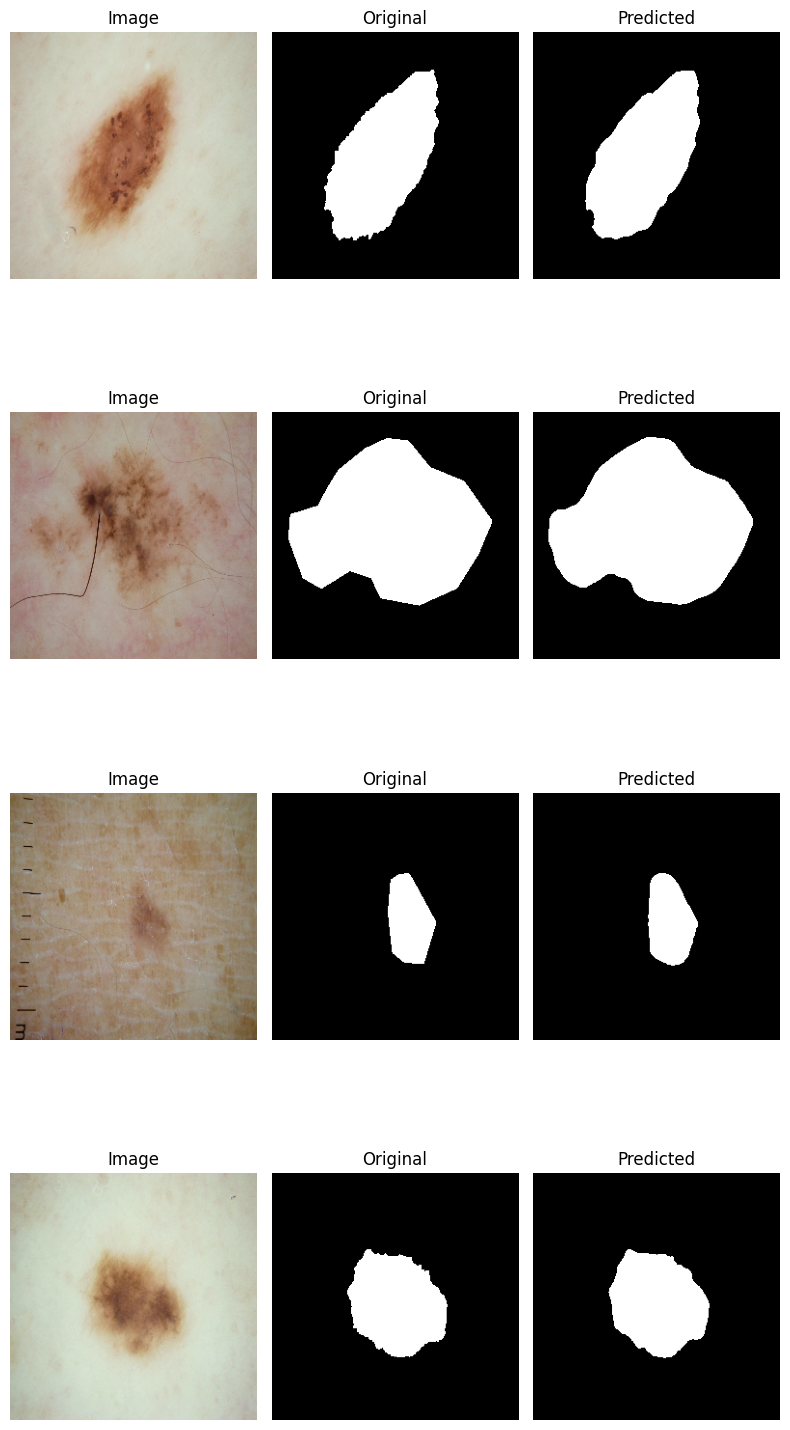

In [24]:
NUM_CLASSES = 1
LEARNING_RATE = 1e-4

test_images, test_masks = next(iter(test_dataset))

# Attention U-Net with original data
model_attention_original = Attention_UNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES=NUM_CLASSES)
model_attention_original.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_attention_original.load_weights('/content/drive/MyDrive/DLMIA/Practical_Block_1/checkpoints/attention_unet_original.h5')

# Predictions
pred_masks = model_attention_original.predict(test_images)
pred_masks = (pred_masks >= 0.5).astype(int)

plot_results(test_images, test_masks, pred_masks)

In [25]:
p = 0
final_metrics = []
for i in tqdm(range(len(test_set) // BATCH_SIZE)):
  image, mask = next(iter(test_dataset))

  pred_attention_original = model_attention_original.predict(image, verbose=0)
  pred_attention_original = (pred_attention_original >= 0.5).astype(int)

  for j in range(mask.shape[0]):
    final_metrics.append(binary_mask_metrics(mask[j], pred_attention_original[j]))

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image[j])
    axs[0].axis('off')
    axs[1].imshow(pred_attention_original[j], cmap='gray')
    axs[1].axis('off')
    fig.tight_layout()
    fig.savefig(f'/content/drive/MyDrive/DLMIA/Practical_Block_1/results/attention_original/pred_{i}.png')
    p += 1

Output hidden; open in https://colab.research.google.com to view.

In [26]:
results_test = {}

for d in final_metrics:
    for key, value in d.items():
        if key in results_test:
            results_test[key] += value
        else:
            results_test[key] = value

num_dicts = len(final_metrics)
for key in results_test:
    results_test[key] /= num_dicts

print(results_test)

{'Accuracy': 0.9859005321155895, 'Sensitivity': 0.9799152366564509, 'Specificity': 0.9870078832434903, 'F1 Score': 0.9673776131870487, 'Dice Coefficient': 0.9673776131870487, 'Jaccard Index': 0.9388948345796525, 'ROC AUC': 0.983461559949971}


In [28]:
# Define row names
row_names = ['Attention U-Net Original']

df_results_test = pd.DataFrame([results_test], index=row_names)
df_results_test

Accuracy  Sensitivity  Specificity  F1 Score  \
Attention U-Net Original  0.985901     0.979915     0.987008  0.967378   

                          Dice Coefficient  Jaccard Index   ROC AUC  
Attention U-Net Original          0.967378       0.938895  0.983462

We can see that the values of the metrics for the selected model are very similar to the ones obtained with the validation set. We can say that the final Jaccard Index of our segmentation is of 0.9388 which is very high.

--------------

As a conclusion of this first practical exercise, we have developed a mole segmentation algorithm. We tested the classical U-Net architecture and the state-of-the-art architecture that adds attention for better reconstruction in the decoder part. Our results indicate that the performance of the models with attention is superior to the classical U-Net. In addition, we have tested different data pre-processing techniques and found that using the original data in combination with the U-Net with attention produces better performance compared to more advanced and complicated pre-processing.